# Realized Volatility Prediction
## 2 Exploratory Data Analysis

### Table of Contents
1. Introduction and Imports
2. Target Values (train.csv)
3. Book and Trade Data
4. Realized Volatility Calculation

## 2.1 Introduction and Imports

We have ensured that the data is clean enough to proceed and gained some insights into data organization. In this step, we will examine the dataset more closely. First, we will examine the target values to get a better idea of the expected range of our model outputs. Then, we will examine some example buckets of book data and visualize the time series. We will also examine the values in the trade data. Finally, we will look into the theory behind realized volatility calculation and come up with some candidate features to predict this value.

In [1]:
# Standard imports and libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File paths
target = pd.read_csv('../data/raw/train.csv')
book_path = '../data/raw/book_train.parquet/stock_id='
trade_path = '../data/raw/trade_train.parquet/stock_id='

## 2.2 Target Values (train.csv)

What range do we expect realized volatility to be in?

In [3]:
target.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [4]:
target.target.describe()

count    428932.000000
mean          0.003880
std           0.002936
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070321
Name: target, dtype: float64

/Users/hao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Count'>

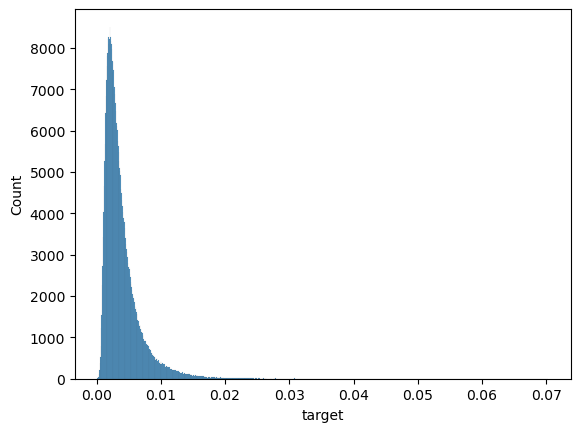

In [5]:
sns.histplot(data=target, x='target')

As the distribution is right skewed and has a long tail, let us plot on a log_scale to better observe.

/Users/hao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Count'>

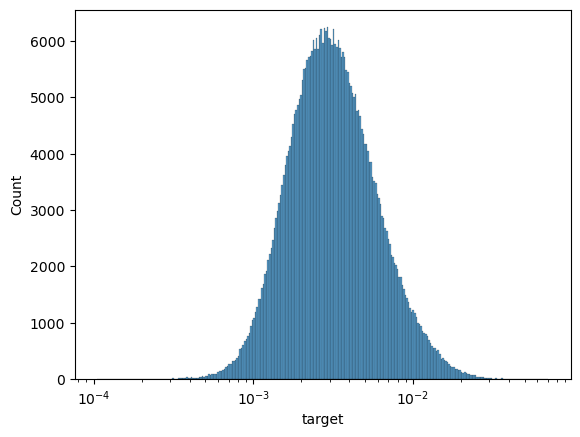

In [6]:
sns.histplot(data=target, x='target', log_scale=True)

## 2.3 Book Data

Now let's turn our attention to book data. Let us pick a sample bucket to understand better what information book data contains. Here we arbitrarily choose row 117519 of target values

In [7]:
target.iloc[[117519]]

,stock_id,time_id,target
117519,33,21834,0.003207


In [8]:
stock_id = 33
time_id = 21834

book_file = pd.read_parquet(book_path + str(stock_id))
book_bucket = book_file[book_file['time_id'] == time_id].copy()

book_bucket.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
530254,21834,0,0.999342,1.000554,0.999321,1.000679,5,1,105,3
530255,21834,13,0.999321,1.000554,0.999258,1.000679,105,1,102,3
530256,21834,14,0.999321,1.000554,0.999258,1.000679,105,1,102,3
530257,21834,20,0.999321,1.000554,0.999258,1.000679,106,1,102,3
530258,21834,23,0.999342,1.000554,0.999321,1.000679,148,1,57,3


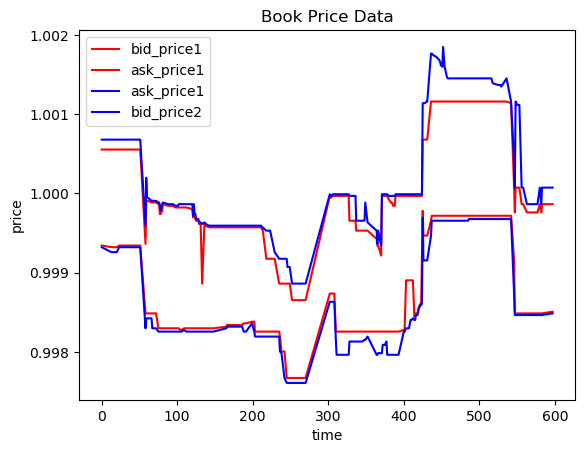

In [9]:
t = book_bucket['seconds_in_bucket']

fig, ax = plt.subplots()
l1, = ax.plot(t, book_bucket['bid_price1'], c='r')
l2, = ax.plot(t, book_bucket['ask_price1'], c='r')
l3, = ax.plot(t, book_bucket['ask_price2'], c='b')
l4, = ax.plot(t, book_bucket['bid_price2'], c='b')

ax.legend((l1,l2,l3,l4), ('bid_price1','ask_price1','ask_price1','bid_price2'))
ax.set_xlabel('time')
ax.set_ylabel('price')
ax.set_title('Book Price Data')
plt.show()

As we can see, the bid and ask price never crossed (or a trade would have been executed automatically). Let us overlay the trade data.

In [10]:
trade_file = pd.read_parquet(trade_path + str(stock_id))
trade_bucket = trade_file[trade_file['time_id'] == time_id].copy()

trade_bucket.head()

,time_id,seconds_in_bucket,price,size,order_count
63934,21834,58,0.999225,368,14
63935,21834,59,0.999363,5,1
63936,21834,75,0.998485,2,1
63937,21834,98,0.998861,5,1
63938,21834,120,0.999091,1,1


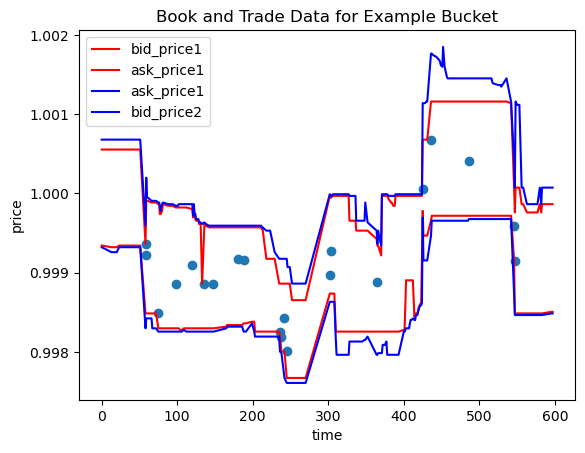

In [11]:
t = book_bucket['seconds_in_bucket']

fig, ax = plt.subplots()
l1, = ax.plot(t, book_bucket['bid_price1'], c='r')
l2, = ax.plot(t, book_bucket['ask_price1'], c='r')
l3, = ax.plot(t, book_bucket['ask_price2'], c='b')
l4, = ax.plot(t, book_bucket['bid_price2'], c='b')


plt.scatter(trade_bucket['seconds_in_bucket'], trade_bucket['price'])

ax.legend((l1,l2,l3,l4), ('bid_price1','ask_price1','ask_price1','bid_price2'))
ax.set_xlabel('time')
ax.set_ylabel('price')
ax.set_title('Book and Trade Data for Example Bucket')
plt.show()

## 2.4 Realized Volatility Calculation

The value we are trying to predict is the volatility for the subsequent 10 minutes. Let us first calculate the volatility for the current 10 minute window. The process is as follows:

1. Calculate the WAP from book data as:

WAP = (bid_price1 * ask_size1 + ask_price1 * bid_size1) / (bid_size1 + ask_size1)

The result should be a time series representing the price of stock.

2. From WAP, calculate log returns

r = log(WAP_t2/WAP_t1)

where r is the log return between t1 and t2. This returns another time series.

3. Compute log returns over the window and calculate the realized volatility as the sqrt of the sum of squared log returns.

Note here only a part of the book data is used; this means the rest of the data will be used to build other signals. We will start with computing the realized volatility for the example bucket.

In [12]:
book_bucket['wap'] = (book_bucket['bid_price1'] * book_bucket['ask_size1'] + 
                      book_bucket['ask_price1'] * book_bucket['bid_size1']
                     ) / (book_bucket['bid_size1']+ book_bucket['ask_size1'])

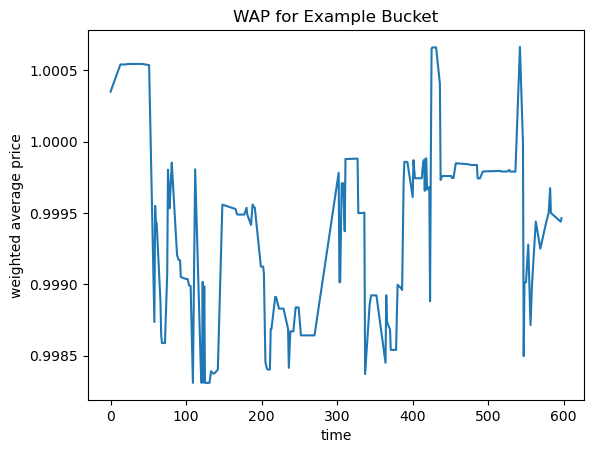

In [13]:
plt.plot(book_bucket['seconds_in_bucket'], book_bucket['wap'])
plt.xlabel('time')
plt.ylabel('weighted average price')
plt.title('WAP for Example Bucket')
plt.show()

In [14]:
# Test WAP for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(book_bucket['wap'].values)

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.2299921172296995
p-value: 0.018312945346171308
Critical Values:
	1%: -3.4668001583460613
	5%: -2.8775552336674317
	10%: -2.5753075498128246


Here we have a sationary series. We can leave data as is.

In [15]:
book_bucket['log_return'] = np.log(book_bucket['wap']).diff()

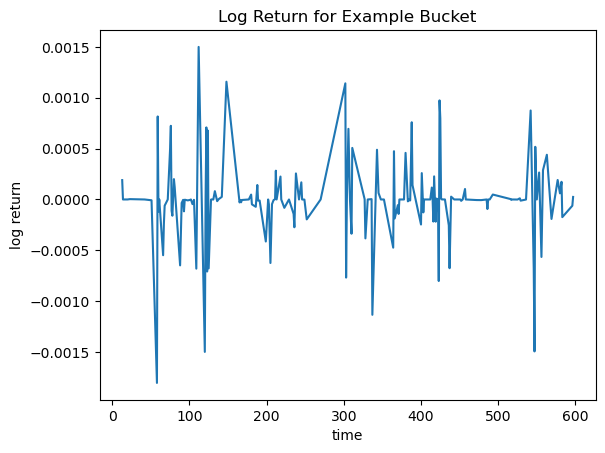

In [16]:
plt.plot(book_bucket['seconds_in_bucket'], book_bucket['log_return'])
plt.xlabel('time')
plt.ylabel('log return')
plt.title('Log Return for Example Bucket')
plt.show()

In [17]:
realized_volatility = np.sqrt(np.sum(book_bucket['log_return']**2))
print('realized_volatility for bucket with stock_id=', stock_id, 'and time_id=', time_id, 'is', realized_volatility)

realized_volatility for bucket with stock_id= 33 and time_id= 21834 is 0.00530235206273329


## Summary
During this step we found out that the target feature, realized volatility, follows a log-normal distribution. We then plotted the book and trade data for an example bucket and tested for stationarity. In the next step, we will build features, or signals, for each bucket, similar to how we calculated the realized volatility.